In [1]:
!hostname

dev0.altiusinstitute.org


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import scipy.stats as stats

import tensorqtl
from tensorqtl import cis

from pandas_plink import read_plink

import importlib
importlib.reload(tensorqtl)
importlib.reload(cis)

<module 'cis' from '/home/jvierstra/.local/miniconda3/envs/py3.8_tensorqtl/lib/python3.8/site-packages/tensorqtl/cis.py'>

In [3]:
plink_prefix_path = '/net/seq/data/projects/regulotyping-phaseI+II/dnase/qtl/all/results/plink/plink'
phenotype_bed_path = '/net/seq/data/projects/regulotyping-phaseI+II/dnase/qtl/all/results/matrix_counts.norm.bed.gz'
covariates_path = '/net/seq/data/projects/regulotyping-phaseI+II/dnase/qtl/all/results/plink/plink.eigenvec'

region = 'chr14:1-25000000'
window = 500000

In [4]:
def unpack_region(s):
    (chrom, coords) = s.split(":")
    (start, end) = coords.split("-")
    return chrom, int(start), int(end)

(region_chrom, region_start, region_end) = unpack_region(region)

prefix = region
output_dir = '.'

## Load covariates

Here we use the first 10 PCs from PCA of genotype file (using plink).

In [5]:
covariates_df = pd.read_table(covariates_path, header=0)
covariates_df = covariates_df.drop(columns=covariates_df.columns[0]).rename(columns = {"IID": "indiv_id"}).set_index("indiv_id")

covariates_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
indiv_id,,,,,,,,,,
Allcells_10055,-0.049800,-0.053049,-0.005509,-0.002902,-0.000703,0.001458,-0.000472,0.001186,-0.001225,0.000888
Allcells_10274,-0.048348,-0.046933,-0.005146,-0.003060,-0.002348,0.001159,-0.000847,0.000708,0.000468,0.002372
Allcells_10342,-0.042775,0.012301,0.000401,-0.001277,-0.001168,0.000663,0.000421,0.000664,-0.000804,0.000667
Allcells_10345,-0.040793,0.179409,0.019520,0.008933,0.002791,-0.001882,0.000458,-0.000606,0.001242,-0.002172
Allcells_10532,-0.041961,0.190247,0.022174,0.009612,0.002542,-0.002397,0.002337,-0.001577,0.000240,-0.003310


## Load phenotype data

Here we are detect chromatin QTLS (caQTLs). This file is a matrix with 4+N columns. The first 4 columns are ``chr``, ``start``,``end`` and ``phenotype_id``. Columns 5-N are the samples. In eQTL studies each row refers to a gene (TSS).

This matrix is highly normalized (read depth, GC-content, mean-center scaled and quantile normalized). See `normalize.py` script for reference.

In [6]:
!zcat {phenotype_bed_path} | head | cut -f1-5

#chr	start	end	phenotype_id	Allcells_11748>h.CD3+
chr1	10110	10111	chunk0001_1_1	-1.2791
chr1	10290	10291	chunk0001_2_1	-0.6147
chr1	10570	10571	chunk0001_4_1	0.5695
chr1	13330	13331	chunk0001_5_1	-0.7481
chr1	13970	13971	chunk0001_6_1	0.3111
chr1	15240	15241	chunk0001_7_1	-0.7248
chr1	15930	15931	chunk0001_10_1	0.1865
chr1	16230	16231	chunk0001_10_2	-1.9374
chr1	17490	17491	chunk0001_11_1	-2.3511

gzip: stdout: Broken pipe


In [7]:
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(phenotype_bed_path)

# select phenotypes in genomic range specified above
select_phenotypes = (phenotype_pos_df['chr']==region_chrom) & (phenotype_pos_df['tss']>region_start) & (phenotype_pos_df['tss']<=region_end)

phenotype_df = phenotype_df[select_phenotypes]
phenotype_pos_df = phenotype_pos_df[select_phenotypes]

In [9]:
phenotype_df.head()

,Allcells_11748>h.CD3+,Allcells_11503>h.CD4.Treg,Allcells_11917>h.CD4.Treg,Allcells_11714>h.CD56+,Allcells_11917>h.CD56+,Allcells_10749>h.CD56+,Allcells_11999>h.CD4.Treg,Allcells_11503>h.CD56+,Allcells_11126>h.CD56+,Allcells_12239>h.CD56+,...,Stemcell_RG1424>h.CD19+,Stemcell_CE0005875>h.CD19+,Stemcell_RV01000552>h.CD3+,Stemcell_RG1792>h.CD3+,Stemcell_RG1820>h.CD3+,Stemcell_RG1213>h.CD3+,Stemcell_RG2402>h.CD14+,Stemcell_RB1085>h.CD19+,Stemcell_RV01000585>h.CD3+,Stemcell_RG1871>h.CD19+
phenotype_id,,,,,,,,,,,,,,,,,,,,,
chunk1053_1_1,-2.1864,-0.3221,-2.5319,1.2611,-1.0428,-0.5740,1.1919,1.4207,0.5920,0.3701,...,0.4931,1.3830,0.2819,1.0127,-1.6139,-0.8484,-2.9443,0.0286,0.4050,1.3889
chunk1053_2_1,0.1913,0.3091,0.6132,1.3122,-0.4137,0.7756,1.1928,-0.7901,-0.9401,-0.7071,...,-0.1953,1.3641,-0.3234,-0.0548,-1.3130,-0.1906,-1.9744,1.2919,0.0329,1.8046
chunk1053_3_1,0.3092,0.6573,1.6495,0.9023,-1.3202,-1.5803,-1.3694,-2.1288,-0.4358,0.2761,...,0.9630,1.2078,-0.4538,-0.4929,-2.3299,0.9646,-1.2662,1.5780,-1.3614,0.6329
chunk1053_4_1,0.0734,-0.5996,-0.2188,-1.1132,-0.8699,-0.6284,-0.7904,1.5167,0.6391,0.0788,...,-0.1455,-0.3339,0.5819,0.9316,-0.3148,0.8678,-1.4328,1.0608,-0.0227,-0.3295
chunk1053_5_1,-1.7936,0.9260,1.6385,1.6269,-0.5360,0.6175,-0.1037,-0.5909,1.0943,-1.0640,...,0.8006,0.5391,0.8472,0.9854,-0.7122,1.2430,-2.2304,-1.6691,0.3007,0.6009


In [10]:
phenotype_pos_df.head()

,chr,tss
phenotype_id,,
chunk1053_1_1,chr14,16022931
chunk1053_2_1,chr14,16023291
chunk1053_3_1,chr14,16024771
chunk1053_4_1,chr14,16025931
chunk1053_5_1,chr14,16030791


## Create the sample dataframe

Create a dataframe that maps the regression interactions to sample id. In this case, we are regressing against the celltype. **The values in the ``indiv_id`` columns must be found the in genotype file!**

In [11]:
phenotype_sample_df = phenotype_df.columns.str.split('>', expand=True).to_frame(index=False)
phenotype_sample_df = phenotype_sample_df.rename(columns={0: 'indiv_id', 1: 'celltype'})
phenotype_sample_df = phenotype_sample_df.assign(sample_id=phenotype_df.columns)
phenotype_sample_df.head()

,indiv_id,celltype,sample_id
0,Allcells_11748,h.CD3+,Allcells_11748>h.CD3+
1,Allcells_11503,h.CD4.Treg,Allcells_11503>h.CD4.Treg
2,Allcells_11917,h.CD4.Treg,Allcells_11917>h.CD4.Treg
3,Allcells_11714,h.CD56+,Allcells_11714>h.CD56+
4,Allcells_11917,h.CD56+,Allcells_11917>h.CD56+


## Load genotypes (w/ pandas_plink)

In [12]:
print("Scanning genotype data...")

bim, fam, bed = read_plink(plink_prefix_path, verbose=True)

bed = 2 - bed # flip alleles; alternative is coded as 1 in pandas plink
bed[np.isnan(bed)] = -1  # convert missing (NaN) to -1 for int8
bed = bed.astype(np.int8, copy=False)

# Filter chromosomes
#m = bim['chrom'].isin(include_chrs).values

windowed_region_start = (region_start - window)
windowed_region_end = (region_end + window)

m = (bim['chrom'].isin([region_chrom]).values) & (bim['pos']>windowed_region_start) & (bim['pos']<=windowed_region_end)

bed = bed[m,:]
bim = bim[m]
bim.reset_index(drop=True, inplace=True)
bim['i'] = bim.index

# Filter samples
fam_sample_ids = fam['iid'].tolist()

Scanning genotype data...


Mapping files: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.02s/it]


In [13]:
# Restrict to individuals in genotype file
i = phenotype_sample_df['indiv_id'].isin(fam_sample_ids)
phenotype_sample_df = phenotype_sample_df[i]

# Reform covariates to match samples (in this case we replicate rows since each individual is found mulitple times)
covariates_df = covariates_df.loc[phenotype_sample_df['indiv_id']]
covariates_df.index = phenotype_sample_df['sample_id']

# Restrict samples in the phenotypes df to match genotypes, etc.
phenotype_df = phenotype_df[phenotype_sample_df['sample_id']]

# Check to make sure everything "adds up"
assert np.all(phenotype_df.columns==covariates_df.index)

## Load genotype data

In [14]:
ix = [fam_sample_ids.index(i) for i in phenotype_sample_df['indiv_id']]

print("Found {} samples in both genotype and phenotype files!".format(len(ix)))

bed = bed[:, ix]

genotype_df = pd.DataFrame(bed.compute(), index=bim['snp'], columns=phenotype_sample_df['sample_id'])
variant_df = bim.set_index('snp')[['chrom', 'pos']]

Found 680 samples in both genotype and phenotype files!


## Run QTL

### Full model

In [15]:
# '+ g' sets CD14+ as baseline; g:celltype coefficients are then relative to this
# useful to detect cell-selective variants
formula = 'p ~ C(celltype) + g + g:C(celltype) - 1'

res_full = cis.map_nominal_interactions(genotype_df, variant_df, phenotype_df, phenotype_pos_df,
                                phenotype_sample_df, formula=formula,
                                covariates_df=None, window=window)

cis-QTL interaction mapping: nominal associations for all variant-phenotype pairs
  * 680 samples
  * 6470 phenotypes
  * 45496 variants
  * p ~ C(celltype) + g + g:C(celltype) - 1
     - 3 terms
  * 10 interactions:
     - C(celltype)[h.CD14+]
     - C(celltype)[h.CD19+]
     - C(celltype)[h.CD3+]
     - C(celltype)[h.CD4.Treg]
     - C(celltype)[h.CD56+]
     - g
     - g:C(celltype)[h.CD19+]
     - g:C(celltype)[h.CD3+]
     - g:C(celltype)[h.CD4.Treg]
     - g:C(celltype)[h.CD56+]
  * checking phenotypes: 6470/6470
    ** dropping 53 phenotypes without variants in cis-window
  * Computing associations
    Mapping chromosome chr14
    processing phenotype 45/6417

/home/jvierstra/.local/miniconda3/envs/py3.8_tensorqtl/lib/python3.8/site-packages/tensorqtl/eigenmt.py:108: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2524.)
  eigenvalues0_t,_ = torch.symeig(shrunk_cor0_t, eigenvectors=False)


    processing phenotype 6417/6417
    time elapsed: 28.99 min
done.


In [16]:
res_full.head()

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,f,r2,sse,dfe,...,pval_g:C(celltype)[h.CD3+],b_g:C(celltype)[h.CD3+],b_se_g:C(celltype)[h.CD3+],pval_g:C(celltype)[h.CD4.Treg],b_g:C(celltype)[h.CD4.Treg],b_se_g:C(celltype)[h.CD4.Treg],pval_g:C(celltype)[h.CD56+],b_g:C(celltype)[h.CD56+],b_se_g:C(celltype)[h.CD56+],pval_f
0,chunk1053_81_1,rs78432465,248992,0.210294,241,286,3.432462,0.044075,706.660583,670.0,...,0.046537,-0.411023,0.206111,0.140571,-0.304685,0.206508,0.085519,-0.331784,0.192666,0.000381
1,chunk1053_82_1,rs78432465,226492,0.210294,241,286,1.849276,0.024239,525.700989,670.0,...,0.871478,-0.028771,0.177773,0.207726,-0.224614,0.178115,0.577204,-0.092684,0.166177,0.056682
2,chunk1053_83_1,rs78432465,220512,0.210294,241,286,4.130796,0.052571,208.014252,670.0,...,0.077150,-0.197953,0.111826,0.433785,0.087751,0.112041,0.338830,-0.100054,0.104531,0.000034
3,chunk1053_84_1,rs78432465,219162,0.210294,241,286,2.797849,0.036222,576.049133,670.0,...,0.222064,-0.227440,0.186091,0.330745,-0.181475,0.186450,0.135492,-0.259988,0.173952,0.003145
4,chunk1053_85_1,rs78432465,209472,0.210294,241,286,4.818521,0.060792,524.587769,670.0,...,0.012365,0.445442,0.177585,0.497681,0.120725,0.177927,0.062516,0.309712,0.166001,0.000003


### Reduced model

In [17]:
formula = 'p ~ C(celltype) - 1'

res_reduced = cis.map_nominal_interactions(genotype_df, variant_df, phenotype_df, phenotype_pos_df,
                                phenotype_sample_df, formula=formula,
                                covariates_df=None, window=window)

cis-QTL interaction mapping: nominal associations for all variant-phenotype pairs
  * 680 samples
  * 6470 phenotypes
  * 45496 variants
  * p ~ C(celltype) - 1
     - 1 terms
  * 5 interactions:
     - C(celltype)[h.CD14+]
     - C(celltype)[h.CD19+]
     - C(celltype)[h.CD3+]
     - C(celltype)[h.CD4.Treg]
     - C(celltype)[h.CD56+]
  * checking phenotypes: 6470/6470
    ** dropping 53 phenotypes without variants in cis-window
  * Computing associations
    Mapping chromosome chr14
    processing phenotype 6417/6417
    time elapsed: 27.81 min
done.


## Compare full and reduced model w/ ANOVA

$F^* = \frac{\frac{SSE_R - SSE_F}{df_R - df_F}}{\frac{SSE_F}{df_F}}$

In [19]:
f = ((res_reduced['sse']-res_full['sse'])/(res_reduced['dfe']-res_full['dfe'])) / (res_full['sse']/res_full['dfe'])
p = stats.f.sf(f, res_reduced['dfe']-res_full['dfe'], res_full['dfe'])

res_full['f_anova'] = f
res_full['pval_anova'] = p

In [99]:
i = res_full.loc[res_full['pval_anova']<1e-10].iloc[51].name

res_full.loc[i]

phenotype_id                      chunk1058_183_1
variant_id                              rs7158086
tss_distance                                 6481
af                                       0.581618
ma_samples                                    430
ma_count                                      569
f                                       21.619652
r2                                       0.225054
sse                                    181.093689
dfe                                         670.0
m_eff                                         440
pval_C(celltype)[h.CD14+]                0.000972
b_C(celltype)[h.CD14+]                   0.251406
b_se_C(celltype)[h.CD14+]                0.075882
pval_C(celltype)[h.CD19+]                     0.0
b_C(celltype)[h.CD19+]                   0.544942
b_se_C(celltype)[h.CD19+]                0.076414
pval_C(celltype)[h.CD3+]                      0.0
b_C(celltype)[h.CD3+]                    1.011257
b_se_C(celltype)[h.CD3+]                 0.112535


Text(0.5, 1.0, 'chunk1058_183_1 : rs7158086')

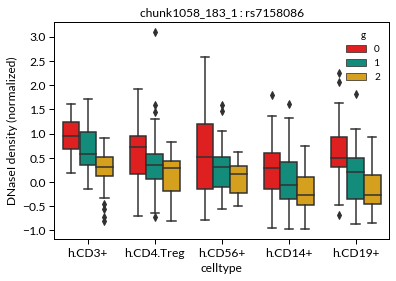

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

phe = res_full.loc[i,'phenotype_id']
var = res_full.loc[i, 'variant_id']

df = phenotype_sample_df.assign(g=genotype_df.loc[var].values, p=phenotype_df.loc[phe].values)

colors= {
    0: '#FF0000',
    1: '#00A08A', 
    2: '#F2AD00', 
}

g = sns.boxplot(data=df, x='celltype', y='p', hue='g', palette=colors, width=0.75)

# celltypes = [t.get_text() for t in g.get_xticklabels()]

# b = res_full.loc[i, [f'b_g:C(celltype)[{celltype}]' for celltype in celltypes]].values
# intercept = res_full.loc[i, [f'b_C(celltype)[{celltype}]' for celltype in celltypes]].values

# for i in range(len(celltypes)):
#     x = np.array([i-0.25, i+0.25])
#     y = [intercept[i], intercept[i] + b[i]*2]
    
#     g.plot(x, y, lw=5, color='w', alpha=0.75, zorder=10)
#     g.plot(x, y, color='k', ls='dashed', zorder=10)

g.set_ylabel('DNaseI density (normalized)')
g.set_title(f'{res_full.loc[i,"phenotype_id"]} : {res_full.loc[i, "variant_id"]}')
